# 1. Setup
We start off by importing the Python libraries we need. We also import the `essays` dataset (`essays.csv`) that we can find in the `data` directory of our project.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

essays_raw = pd.read_csv('data/essays.csv', engine='python');

def clean_colnames(df):
    df.columns = df.columns.str.replace("c|#", "").str.lower()
    return df
    
essays_raw = clean_colnames(essays_raw)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BiegT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. Inpect the data

Let's take a quick look at the structure of the `essays` dataset.

In [2]:
# Print the first few rows of the dataset
print(essays_raw.head())

# Print the number of rows and colums
print("\nNumber of rows and columns: {} \n".format(essays_raw.shape))

# Check if author ids are unique
if len(essays_raw['authid']) == len(essays_raw):
    print('All author ids are unique!')
else:
    print('Author ids are not unique!')
    
# Check if there are missing values in the dataset:
essays_raw.isnull().sum()

            authid                                               text ext neu  \
0  1997_504851.txt  Well, right now I just woke up from a mid-day ...   n   y   
1  1997_605191.txt  Well, here we go with the stream of consciousn...   n   n   
2  1997_687252.txt  An open keyboard and buttons to push. The thin...   n   y   
3  1997_568848.txt  I can't believe it!  It's really happening!  M...   y   n   
4  1997_688160.txt  Well, here I go with the good old stream of co...   y   n   

  agr con opn  
0   y   n   y  
1   y   n   n  
2   n   y   y  
3   y   y   n  
4   y   n   y  

Number of rows and columns: (2467, 7) 

All author ids are unique!


authid    0
text      0
ext       0
neu       0
agr       0
con       0
opn       0
dtype: int64

We can see that we have a datasset containing 2467 essays from the same number of individual authors. We can also see that the dataset does not contain any missing values. Each essay is associated with an author id and 5 binary labels (one label per personality dimension):

* Extraversion (`ext`)
* Neuroticism (`neu`)
* Agreeableness (`agr`)
* Conscientiousness (`con`)
* Openess (`opn`)

Note that in psychological theory, the Big Five model actually considers all five traits as independent continious dimensions (and even defines sub dimensions - so-called facets - for each of them). However, for this machine learning task, the labels in our datasets represent just binary categories (e.g. a value of `y` in the `neu`-column indicates that the author of the given essay is neurotic).

Obviously, our goal is to predict the five binary labels for a given essay. In the other words, the task at hand is a binary multi label classification task. Before we create a train-test split and preprocess our data, let's explore it a little bit further. For example we can look at the distribution of labels for each dimension.

In [3]:
label_counts = pd.melt(essays_raw.iloc[:, 2:7].apply(pd.Series.value_counts).reset_index().copy(),
                       id_vars = ['index'], var_name = 'dimension', value_name = 'count').rename(columns = {'index': 'label'})

label_counts

,label,dimension,count
0,n,ext,1191
1,y,ext,1276
2,n,neu,1234
3,y,neu,1233
4,n,agr,1157
5,y,agr,1310
6,n,con,1214
7,y,con,1253
8,n,opn,1196
9,y,opn,1271


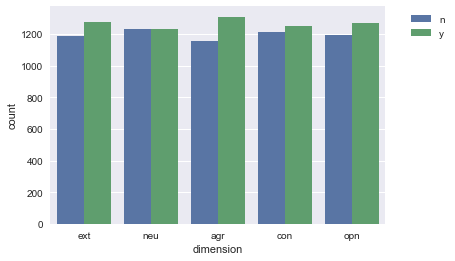

In [4]:
sns.barplot(x = "dimension", y = "count", hue = "label", data = label_counts)
plt.legend(loc = 'center right')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2)

In the plot we can see that for each dimension the number of samples on the positive class (`y`) is roughly equal to the number of samples of the negative class (`n`). In other words, our dataset is appears to be pretty balanced (at least, if you look at each dimension separatly) Let's also look at the counts of individual combinations of dimensions:

32

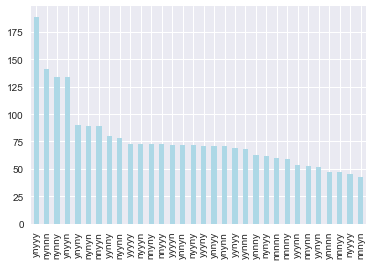

In [5]:
indiv_combs = (essays_raw['ext'] + essays_raw['neu'] + essays_raw['agr'] + essays_raw['con'] + essays_raw['opn']). \
               value_counts()

indiv_combs.plot(kind = "bar", color = "lightblue")
len(indiv_combs)

From the plot above we can see that the individual combinations of dimensions are not equally frequent. Depending on how we attempt to solve our classification problem later on, this is something we want to keep in mind.

As another exploration step, let's take a look at the number of characters in the `text`-column:

AxesSubplot(0.125,0.125;0.775x0.755)


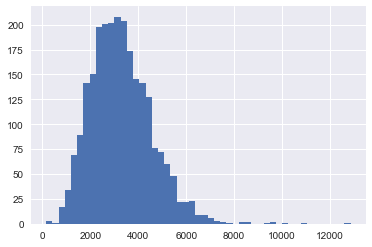

In [6]:
char_counts = essays_raw.text.str.len()

print(char_counts.hist(bins = int(np.sqrt(len(essays_raw)))))

Most essays appear to be between 2000 and 4000 characters long. There appear to some outliers as well (e.g. at least one essay with more than 12000 characters). This is something we want to keep in mind for later, as well.

Also, we should look at some sample essays to see which kind of preprocessing we should to later on:

In [7]:
essays_raw.text[0]

'Well, right now I just woke up from a mid-day nap. It\'s sort of weird, but ever since I moved to Texas, I have had problems concentrating on things. I remember starting my homework in  10th grade as soon as the clock struck 4 and not stopping until it was done. Of course it was easier, but I still did it. But when I moved here, the homework got a little more challenging and there was a lot more busy work, and so I decided not to spend hours doing it, and just getting by. But the thing was that I always paid attention in class and just plain out knew the stuff, and now that I look back, if I had really worked hard and stayed on track the last two years without getting  lazy, I would have been a genius, but hey, that\'s all good. It\'s too late to correct the past, but I don\'t really know how to stay focused n the future. The one thing I know is that when  people say that b/c they live on campus they can\'t concentrate, it\'s b. s. For me it would be easier there, but alas, I\'m livin

The text looks pretty messy: For example, there are a lot of special characters and abbreviations. This is not optimal if you want to feed the text to a model.

# 3. Preprocessing

In this part, we will create a nice and clean dataset that we can feed into a machine learning model.
First, we drop the `authid` column because we actually do not need it for the classification task. Note that we define a function for each preprocessing step, so that we have the option to build a pipeline that combines all steps later on. We implement these functions as *fit transformer objects* to be able to feed them into pipelines later on.

## 3.1 Define preprocessing functions

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin

class ColDropper(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, df):
        return self
    
    def transform(self, df):
        df = df.drop(["authid"], axis = 1)
        return df
    
dropper = ColDropper()
dropper.transform(essays_raw.copy()).head()

,text,ext,neu,agr,con,opn
0,"Well, right now I just woke up from a mid-day ...",n,y,y,n,y
1,"Well, here we go with the stream of consciousn...",n,n,y,n,n
2,An open keyboard and buttons to push. The thin...,n,y,n,y,y
3,I can't believe it! It's really happening! M...,y,n,y,y,n
4,"Well, here I go with the good old stream of co...",y,n,y,n,y


We also implement a class that converts the `y` labels to 1s on the `n` labels to 0s for each personality dimension. This is neccessary because most algorithms can only handle numeric labels.

In [9]:
class LabelTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, df):
        return self
    
    def transform(self, df):
        df['ext'], df['neu'], df['agr'], df['con'], df['opn'] = [[1 if x == 'y' else 0 for x in col] \
                                                                                     for col in [df['ext'],
                                                                                                 df['neu'],
                                                                                                 df['agr'],
                                                                                                 df['con'], 
                                                                                                 df['opn']]]
        return df
    
lbl_trnsfr = LabelTransformer()
lbl_trnsfr.transform(essays_raw.copy()).head()

,authid,text,ext,neu,agr,con,opn
0,1997_504851.txt,"Well, right now I just woke up from a mid-day ...",0,1,1,0,1
1,1997_605191.txt,"Well, here we go with the stream of consciousn...",0,0,1,0,0
2,1997_687252.txt,An open keyboard and buttons to push. The thin...,0,1,0,1,1
3,1997_568848.txt,I can't believe it! It's really happening! M...,1,0,1,1,0
4,1997_688160.txt,"Well, here I go with the good old stream of co...",1,0,1,0,1


As we can see from the output above, the string labels got turned into 0s and 1s.

Next, we create a function to clean the `text` column. This function turns all letters to lower case and removes some abbreviations that are common in the english language. It also removes special characters and multiple consecutive spaces. We also test this function on a sample enssay to ensure that it works as expected.

In [10]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"i’m", "i am ", text)
    text = re.sub('b/c', 'because', text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"’ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

clean_text(essays_raw.text[0])

'well right now i just woke up from a mid day nap it sort of weird but ever since i moved to texas i have had problems concentrating on things i remember starting my homework in 10th grade as soon as the clock struck 4 and not stopping until it was done of course it was easier but i still did it but when i moved here the homework got a little more challenging and there was a lot more busy work and so i decided not to spend hours doing it and just getting by but the thing was that i always paid attention in class and just plain out knew the stuff and now that i look back if i had really worked hard and stayed on track the last two years without getting lazy i would have been a genius but hey that all good it too late to correct the past but i do not really know how to stay focused n the future the one thing i know is that when people say that because they live on campus they can not concentrate it b s for me it would be easier there but alas i am living at home under the watchful eye of

When we take a look at our sample essay now, it looks pretty good. Note that to make things simpler a string like `it's` is striped down to just `it`. We chose to do so because `is` is a typical stopword that we'll remove anyway.

Now, we implement a class `TextCleaner` that applies the `clean_text` function to every row in the `text` column.

In [11]:
class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, pd_series):
        return self
    
    def transform(self, pd_series):
        pd_series = pd_series.apply(clean_text)
        return pd_series

cleaner = TextCleaner()
cleaner.transform(essays_raw['text'].copy()).head()

0    well right now i just woke up from a mid day n...
1    well here we go with the stream of consciousne...
2    an open keyboard and buttons to push the thing...
3    i can not believe it it really happening my pu...
4    well here i go with the good old stream of con...
Name: text, dtype: object

Looks alright. Our preprocessing functions to work fine. So it's time to build pipelines that combine the different preprocessing steps.

## 3.2 Create a training set and a testing set

We create a train test split from the raw data.

In [12]:
train, test = train_test_split(essays_raw, random_state = 1, test_size = 0.2, shuffle = True)

X_train = train['text'].copy()
y_train = train.copy().drop('text', axis = 1)

X_test = test['text'].copy()
y_test = test.copy().drop('text', axis = 1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1973,)
(494,)
(1973, 6)
(494, 6)


## 3.3. Build and apply preprocessing pipelines

We create two pipelines (one for the predictor, one for the labels) that integrate the different preprocessing functions. Note that use the class `TfidfVectorizer`from `sklearn` to tokenize the text data and compute tf-idf statistics. This class can also be used to remove stop words from text input. Stop words are words that occur very frequently and thus do not contain much information about the specific content of a text.

In [13]:
X_prep_pipeline = Pipeline([('txtclean', TextCleaner()),
                            ('tfidf', TfidfVectorizer(stop_words = stop_words))])

y_prep_pipeline = Pipeline([('idcoldrop', ColDropper()),
                            ('lbltransf', LabelTransformer())])

X_train_prepared = X_prep_pipeline.fit_transform(X_train)
y_train_prepared = y_prep_pipeline.fit_transform(y_train)

X_test_prepared = X_prep_pipeline.fit_transform(X_test)
y_test_prepared = y_prep_pipeline.fit_transform(y_test)

# 4. Explore models

In [14]:
# Naive bayes classifier
nb_clf = MultinomialNB(fit_prior = True, class_prior = None)
for category in ['ext', 'neu', 'agr', 'con', 'opn']:
    nb_clf.fit(X_train_prepared, y_train_prepared[category])
    preds = nb_clf.predict(X_train_prepared)
    print('Accuracy for {} using MultinomialNB: {}'.format(category, accuracy_score(y_train_prepared[category], preds)))
    
print('\n')

    # Random forrests
rb_clf = RandomForestClassifier(n_estimators = 200)
for category in ['ext', 'neu', 'agr', 'con', 'opn']:
    rb_clf.fit(X_train_prepared, y_train_prepared[category])
    preds = rb_clf.predict(X_train_prepared)
    print('Accuracy for {} using a RandomForestClassifier: {}'.format(category, accuracy_score(y_train_prepared[category], preds)))

print('\n')
    
log_clf = LogisticRegression(solver='sag')
for category in ['ext', 'neu', 'agr', 'con', 'opn']:
    log_clf.fit(X_train_prepared, y_train_prepared[category])
    preds = log_clf.predict(X_train_prepared)
    print('Accuracy for {} using LogisticRegression: {}'.format(category, accuracy_score(y_train_prepared[category], preds)))


Accuracy for ext using MultinomialNB: 0.747592498732894
Accuracy for neu using MultinomialNB: 0.9574252407501267
Accuracy for agr using MultinomialNB: 0.6031424227065383
Accuracy for con using MultinomialNB: 0.8722757222503801
Accuracy for opn using MultinomialNB: 0.9077546882919412


Accuracy for ext using a RandomForestClassifier: 1.0
Accuracy for neu using a RandomForestClassifier: 1.0
Accuracy for agr using a RandomForestClassifier: 1.0
Accuracy for con using a RandomForestClassifier: 1.0
Accuracy for opn using a RandomForestClassifier: 1.0


Accuracy for ext using LogisticRegression: 0.9229599594526102
Accuracy for neu using LogisticRegression: 0.9183983781044095
Accuracy for agr using LogisticRegression: 0.9102889001520527
Accuracy for con using LogisticRegression: 0.9270146984287887
Accuracy for opn using LogisticRegression: 0.8667004561581348


The RandomForrestClassifer appears to do very well with perfect accuracy for all dimensions, so we further explore this type of model.

Next steps:
* Compute other metrics: F1-score, precision, recall
* Hyperparameter tuning
* Final step: Compute performance metric on test set